In [42]:
import pandas as pd
import numpy as np  
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import validation_curve, learning_curve, train_test_split,GridSearchCV, RandomizedSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')



In [43]:
data = pd.read_csv("./spambase.csv")
data.describe()
# exclude id column
input=data.iloc[:,1:-1]
target=data.iloc[:,-1]

Text(0, 0.5, 'Corrleation')

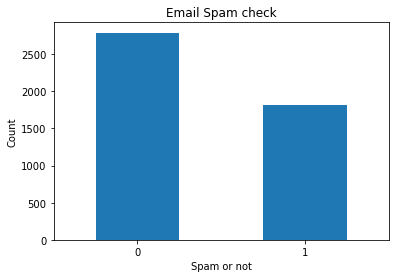

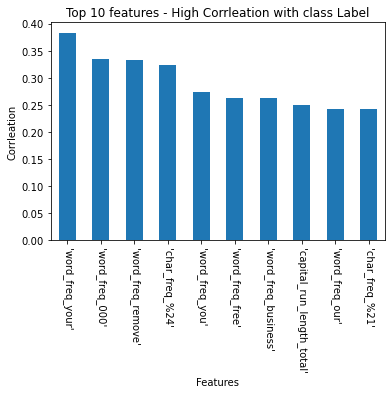

In [44]:
plt.figure()
target.value_counts().plot(kind="bar", title="Email Spam check")
plt.xticks(rotation = 0)
plt.xlabel("Spam or not")
plt.ylabel("Count")

plt.figure()
corr=data.corr()
plt.title("Top 10 features - High Corrleation with class Label")
corr.sort_values(by=["'class'"],ascending=False).iloc[0].sort_values(ascending=False).head(11)[1:].plot(kind="bar")
plt.xticks(rotation = 270)
plt.xlabel("Features")
plt.ylabel("Corrleation")

In [45]:
train_input, test_input, train_target, test_target = train_test_split(input, target,random_state = 42, test_size=0.3)
ss = StandardScaler()
train_input_scaled = ss.fit_transform(train_input)
test_input_scaled = ss.transform(test_input)


In [46]:

def show_validation_curve(learner,param_names,param_ranges, input, target, cv=5):
    for i in range(len(param_names)):
        train_score, test_score = validation_curve(learner, input, target, param_name=param_names[i], param_range=param_ranges[i],cv=cv)
        plt.figure()
        plt.plot(param_ranges[i], np.mean(train_score, axis=1),label='Train Score')
        plt.plot(param_ranges[i], np.mean(test_score, axis=1), label='CV Score')
        plt.xlabel(param_names[i])
        plt.ylabel('Score')
        plt.legend(loc='best')
        
def find_best_params(learner,params,input, target,cv=5):
    gs=GridSearchCV(learner,params, n_jobs=-1, cv=cv)
    gs.fit(input, target)
    best_index = np.argmax(gs.cv_results_['mean_test_score'])
    print(gs.cv_results_['params'][best_index])
    print(gs.best_score_)
    return gs

def show_learning_curve(learner, input, target):        
    train_size, train_score, test_score = learning_curve(learner,input, target, train_sizes=np.linspace(0.1,1,10),cv=5)
    plt.figure()
    plt.plot(train_size,np.mean(train_score,axis=1), label="Train Score")
    plt.plot(train_size,np.mean(test_score,axis=1), label="CV Score")
    plt.legend(loc='best')
    plt.xlabel("Trainning example(%)")
    plt.ylabel("Score")
    plt.show()

def report(learners, train_input, train_target,test_input, test_target):
    trainning_times = []
    test_times = []
    train_scores = []
    test_scores = []
    
    # Calculate each learners fit and test times.
    for learner in learners:        
        train_in = (train_input,train_input_scaled)[learner==nn or learner==svm]
        test_in = (test_input,test_input_scaled)[learner==nn or learner==svm]
        start = time.time()
        learner.fit(train_in, train_target)
        end = time.time()
        trainning_times.append(end-start)
        train_score = learner.score(train_in, train_target)
        start = time.time()        
        test_score = learner.score(test_in, test_target)
        end = time.time()        
        test_times.append(end - start)
        train_scores.append(train_score)
        test_scores.append(test_score)     

    # Show barplot trainning time comparision 
    x_label = ['DT','NN','KNN', 'SVM', 'ADA Boost']
    plt.figure(figsize=(7,6))
    plt.bar(x_label, trainning_times)
    for i, v in enumerate(trainning_times):
        plt.text(i- 0.2, v+0.001 ,str(round(v,4)))
    plt.xlabel('Learners')
    plt.ylabel('Time')
    plt.title('Trainning time by Learners')
    plt.show()  

    # Show barplot test time comparision 
    plt.figure(figsize=(7,6))
    plt.bar(x_label, test_times)
    for i, v in enumerate(test_times):
        plt.text(i- 0.2, v+0.001 ,str(round(v,4)))
    plt.xlabel('Learners')
    plt.ylabel('Time')
    plt.title('Query time by Learners')
    plt.show()

    # Show barplot accuracy scores
    ind = np.arange(len(x_label) )
    width = 0.35       
    plt.figure(figsize=(10,8))
    plt.bar(ind, (train_scores), width, label='Train Score')
    plt.bar(ind + width, (test_scores), width,label='Test Score')
    for i, v in enumerate(train_scores):
        plt.text(i- 0.1, v+0.005 ,str(round(v,2)))
    for i, v in enumerate(test_scores):
        plt.text(i+width-0.1, v+0.005 ,str(round(v,2)))
    plt.xlabel('Learners')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score by Learners')

    plt.xticks(ind + width / 2, x_label)
    plt.legend(loc='best')
    plt.show()

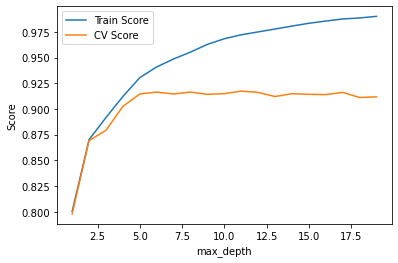

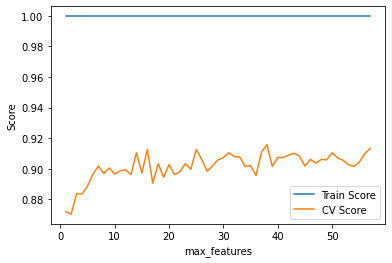

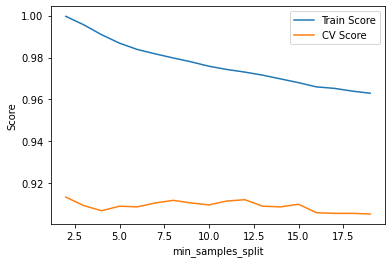

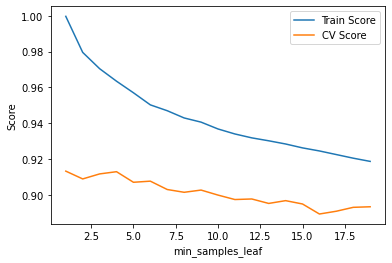

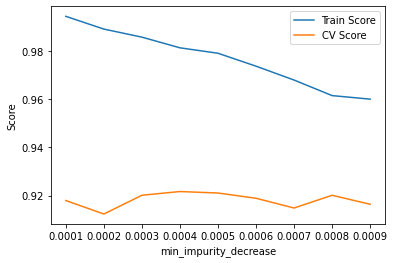

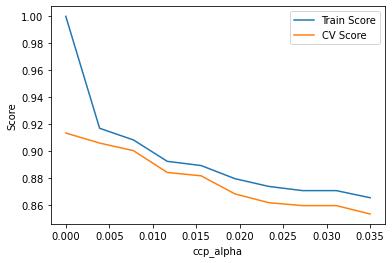

In [47]:
dt = DecisionTreeClassifier(random_state=42)
dt_param_names = ['max_depth','max_features','min_samples_split', 'min_samples_leaf','min_impurity_decrease','ccp_alpha']
dt_param_ranges = [np.arange(1,20),range(1,train_input.shape[1]+1,1),range(1, 20, 1),range(1, 20, 1), np.arange(0.0001,0.001,0.0001),np.linspace(0,0.035,10)]
show_validation_curve(dt, dt_param_names, dt_param_ranges, train_input, train_target)

In [48]:
params = {'max_depth':range(5,20,1),'ccp_alpha': np.linspace(0,0.035,10)}
gs = find_best_params(dt, params,train_input, train_target)
dt=gs.best_estimator_

{'ccp_alpha': 0.0, 'max_depth': 11}
0.9173913043478261


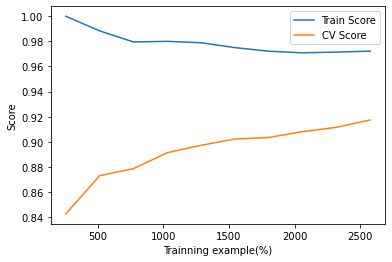

In [49]:
show_learning_curve(dt, train_input, train_target)

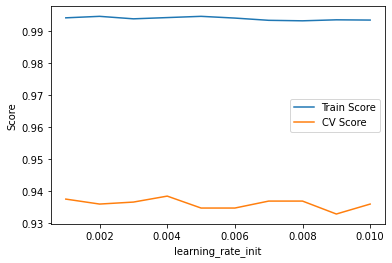

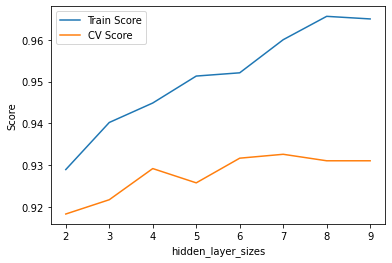

In [50]:
nn = MLPClassifier(max_iter=300,random_state=42)
nn_param_names = ['learning_rate_init','hidden_layer_sizes']#,
nn_param_ranges = [np.linspace(0.001, 0.01,10), range(2,10,1)]
show_validation_curve(nn, nn_param_names, nn_param_ranges, train_input_scaled, train_target)

In [51]:
nn_param_grid = dict(zip(nn_param_names,nn_param_ranges))
nn_gs = find_best_params(nn,nn_param_grid,train_input_scaled, train_target)
nn=nn_gs.best_estimator_

{'hidden_layer_sizes': 8, 'learning_rate_init': 0.002}
0.9335403726708075


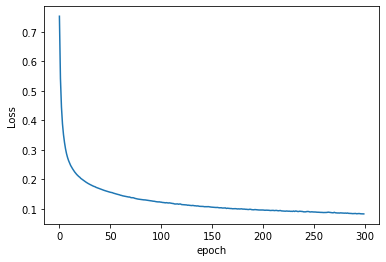

In [52]:
loss = nn.loss_curve_
plt.figure()
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

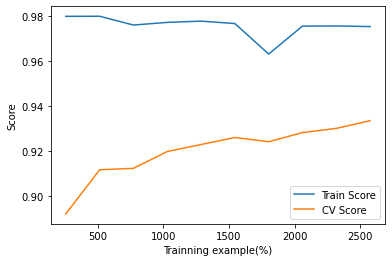

In [53]:
show_learning_curve(nn,train_input_scaled, train_target)

In [54]:
# KNN
knn = KNeighborsClassifier()
 
knn_param_names = ['n_neighbors','metric',"p"]
knn_param_ranges = [range(10,100,10), ['minkowski','euclidean','manhattan'], range(1,5)]

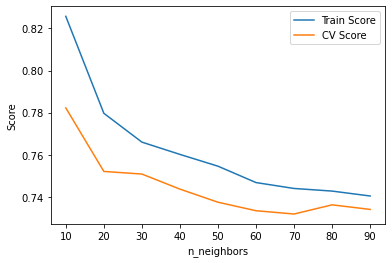

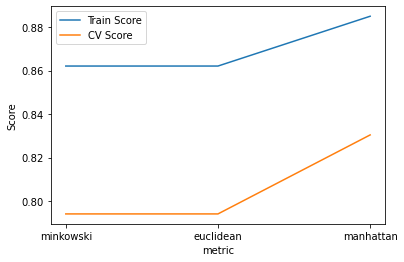

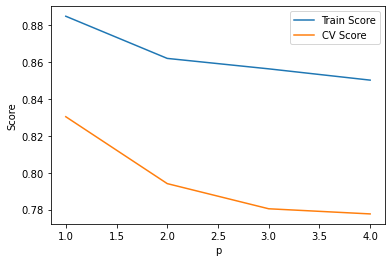

In [55]:
show_validation_curve(knn, knn_param_names, knn_param_ranges, train_input, train_target)

In [56]:
knn_param_grid = dict(zip(knn_param_names,knn_param_ranges))
knn_gs = find_best_params(knn,knn_param_grid, train_input, train_target)
knn=knn_gs.best_estimator_

{'metric': 'minkowski', 'n_neighbors': 10, 'p': 1}
0.8192546583850933


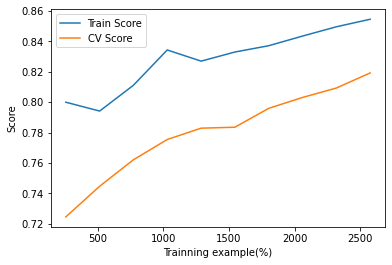

In [57]:
show_learning_curve(knn,train_input, train_target)

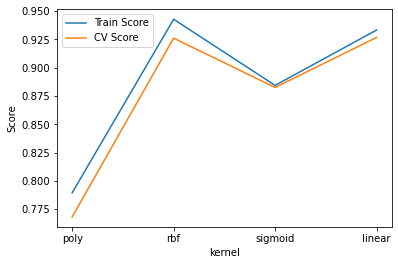

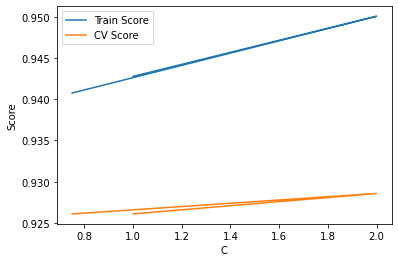

In [58]:
svm = SVC()
svm_param_names = ['kernel', 'C']
svm_param_ranges = [['poly', 'rbf', 'sigmoid','linear'],[1,2,0.75]]
show_validation_curve(svm, svm_param_names, svm_param_ranges,train_input_scaled, train_target)

In [59]:
svm_params = dict(kernel=svm_param_ranges[0],C=svm_param_ranges[1])
svm_gs = find_best_params(svm,svm_params,train_input_scaled,train_target)


{'C': 2, 'kernel': 'rbf'}
0.9285714285714286


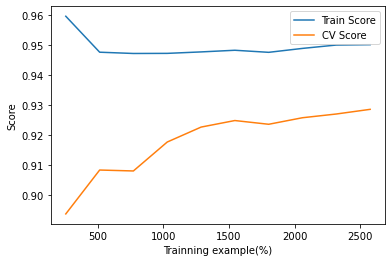

In [60]:
svm=svm_gs.best_estimator_
show_learning_curve(svm, train_input_scaled, train_target)

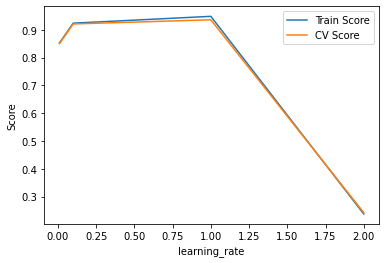

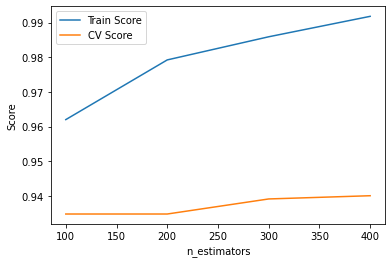

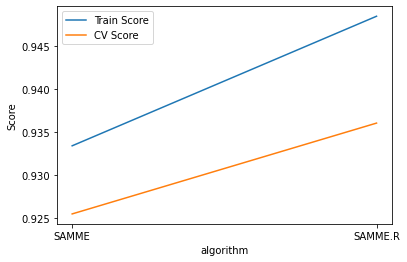

In [61]:
weak = DecisionTreeClassifier(random_state=42,max_depth=1,min_samples_leaf=1)
ada = AdaBoostClassifier(weak)
ada_param_names = ['learning_rate','n_estimators', 'algorithm']
ada_param_ranges = [[0,0.01,0.1,1,2], range(100,500,100), ['SAMME','SAMME.R']]
show_validation_curve(ada, ada_param_names, ada_param_ranges,train_input, train_target)

In [62]:
ada_param_grid = dict(zip(ada_param_names,ada_param_ranges))
ada_gs = find_best_params(ada,ada_param_grid, train_input, train_target)
ada=ada_gs.best_estimator_

{'algorithm': 'SAMME', 'learning_rate': 0, 'n_estimators': 100}
0.9437888198757765


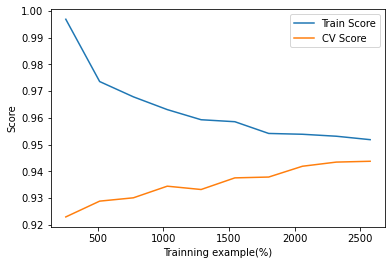

In [63]:
show_learning_curve(ada, train_input, train_target)

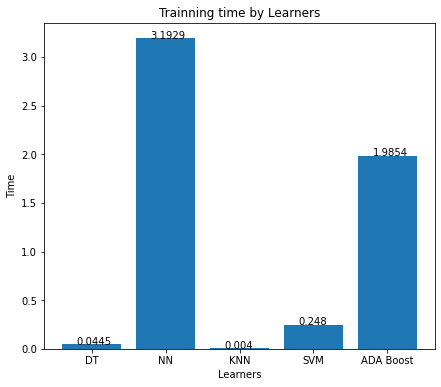

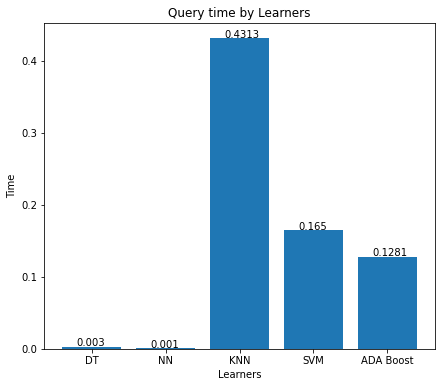

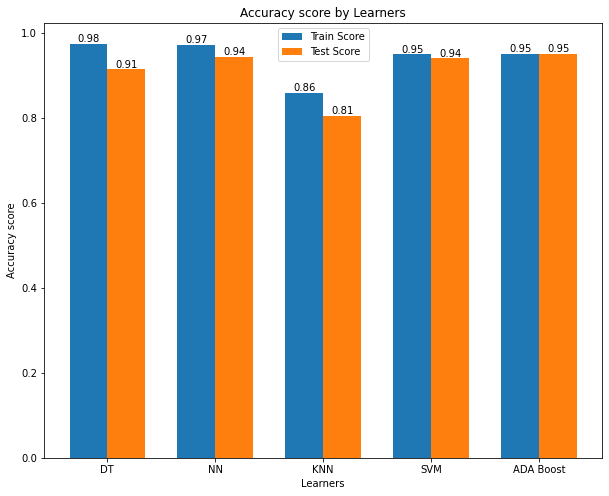

In [64]:
learners = [dt, nn, knn, svm, ada]
report(learners,train_input, train_target, test_input, test_target )